Импортируем нужные библиотеки для обучения, интерполяции и загрузки датасета

In [ ]:
import numpy as np
import torch
import sys
import torchvision
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from torch import nn
from scipy.interpolate import make_interp_spline

Пишем функцию для создания лоадера, так как именно с помощью него мы передаем батчи в нашу сетку

In [2]:
def loader(PATH, transforms):
    dataset = torchvision.datasets.ImageFolder(PATH, transform=transforms)
    loader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle = True, num_workers=8)
    return loader

Пишем функцию обучения, где нейросеть обучаем с помошью обратного распространения ошибки, где критерий берем Кросс-энтропию, а так же считаем метрики(accuracy-точность) на обучающей выборке и на тестовой

In [3]:
def training_with_accuracy(train, test, model, epochs, optimizer, criterion, mass_for_accuracy, device="cuda:0"):
    for epoch in range(epochs):
        model.train()
        total_predictions = np.array([])
        total_labels = np.array([])
        with tqdm(total=len(train), file=sys.stdout) as prbar:
            for images, labels in train:
                images = images.to(device)
                labels = labels.to(device)
                predicted = model(images)
                loss = criterion(predicted, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                prbar.update(1)
                total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
                total_labels = np.append(total_labels, labels.cpu().detach().numpy())
        accuracy = accuracy_score(total_predictions, total_labels)
        print("Epoch: ", epoch, ' accuracy_train: ', accuracy)
        with torch.no_grad():
            model.eval()
            with tqdm(total=len(test), file=sys.stdout) as prbar:
                for images, labels in test:
                    images = images.to(device)
                    labels = labels.to(device)
                    predicted = model(images)
                    prbar.update(1)
                    total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
                    total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            accuracy = accuracy_score(total_predictions, total_labels)
            mass_for_accuracy.append(accuracy)
            print("Epoch: ", epoch, ' accuracy_val: ', accuracy)

Задаем модуль transform, который занимается preprocessing'ом данных, то есть уменьшает размер изображения специально для нашей нейронной сети, а так же проводит нормализацию над каждой картинкой, так как нейросеть показывает более хороший результат если работает с распредленным значением пикселей, то есть не должно быть разброса, в ином случае веса фильтров нейронной сети начнут переобучаться.

In [4]:
transform = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
    ])
val_loader = loader("C:\\Users\\Dmitry\\Desktop\\CNN3\\test", transform)
train_loader = loader("C:\\Users\\Dmitry\\Desktop\\CNN3\\train", transform)
accuracy_resnet50 = []
accuracy_vgg19 = []

Берем предобученные нейронные сети resnet50(с 50 слоями residual connection) и vgg19(с 19 обычными сверточными слоями) и изменяем выходной слой, так как у нас всего 2 класса

In [5]:
resnet50 = models.resnet50(pretrained=True)
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, 2)

In [6]:
vgg19 = models.vgg19(pretrained=True)
vgg19.classifier[0].out_features = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Dmitry/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Задаем количество эпох для обучения, наш критерийЮ по которому будем штрафовать нейронную сеть, и оптимайзер Adam, так как нам надо, чтобы градиенты использовали иннерцию(momentum) и не затухали на большом количестве фотографий

In [7]:
epochs = 5
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
resnet50.to(device)
vgg19.to(device)
optimizer_resnet = torch.optim.Adam(resnet50.parameters(), lr=0.01)
optimizer_vgg = torch.optim.Adam(vgg19.parameters(), lr=0.001)

Обучаем resnet50

In [8]:
training_with_accuracy(train_loader, val_loader, resnet50, epochs, optimizer_resnet, criterion, accuracy_resnet50, device="cuda:0")

  0%|          | 0/506 [00:00<?, ?it/s]

Epoch:  0  accuracy_train:  0.8590147722356141


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch:  0  accuracy_val:  0.8632047351388179


  0%|          | 0/506 [00:00<?, ?it/s]

Epoch:  1  accuracy_train:  0.9056183942147228


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch:  1  accuracy_val:  0.9440895929143246


  0%|          | 0/506 [00:00<?, ?it/s]

Epoch:  2  accuracy_train:  0.9459793559552506


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch:  2  accuracy_val:  0.9764094702776358


  0%|          | 0/506 [00:00<?, ?it/s]

Epoch:  3  accuracy_train:  0.9679831880833178


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch:  3  accuracy_val:  0.9784534150911258


  0%|          | 0/506 [00:00<?, ?it/s]

Epoch:  4  accuracy_train:  0.9783052104580011


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch:  4  accuracy_val:  0.9801992846193153


Обучаем vgg19

In [12]:
training_with_accuracy(train_loader, val_loader, vgg19, epochs, optimizer_vgg, criterion, accuracy_vgg19, device="cuda:0")

  0%|          | 0/506 [00:00<?, ?it/s]

Epoch:  0  accuracy_train:  0.881080412880895


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch:  0  accuracy_val:  0.937446772270482


  0%|          | 0/506 [00:00<?, ?it/s]

Epoch:  1  accuracy_train:  0.6806353915569565


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch:  1  accuracy_val:  0.68042071197411


  0%|          | 0/506 [00:00<?, ?it/s]

Epoch:  2  accuracy_train:  0.7929414673341987


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch:  2  accuracy_val:  0.785705160960654


  0%|          | 0/506 [00:00<?, ?it/s]

Epoch:  3  accuracy_train:  0.7868224241300451


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch:  3  accuracy_val:  0.6618974621018566


  0%|          | 0/506 [00:00<?, ?it/s]

Epoch:  4  accuracy_train:  0.861116261820879


  0%|          | 0/963 [00:00<?, ?it/s]

Epoch:  4  accuracy_val:  0.9332737182762733


Пишем функцию интерполяции для улучшения отображения графиков обучения

In [13]:
def interpolation(mass, iterations):
    x_ = np.arange(0, iterations, step=1)
    y_ = np.asarray(mass)
    spline = make_interp_spline(sorted(x_), y_)
    x = np.linspace(x_.min(), x_.max(), 500)
    y = spline(x)
    return x, y

Строим графики

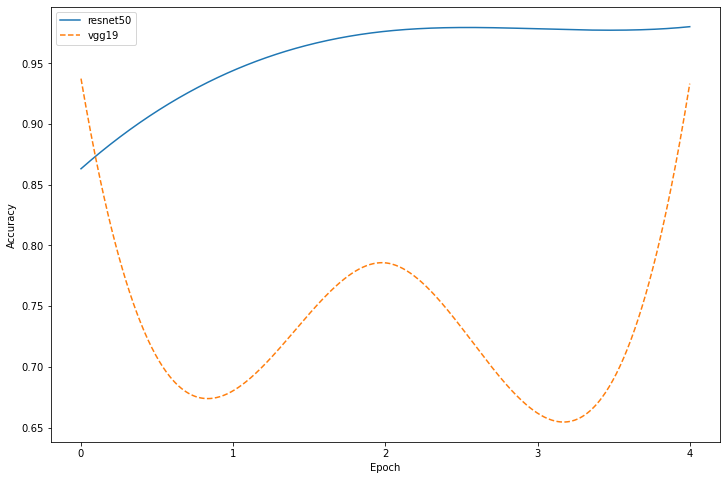

In [14]:
x_vgg, y_vgg = interpolation(accuracy_vgg19, epochs)
x_resnet, y_resnet = interpolation(accuracy_resnet50, epochs)
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.plot(x_resnet, y_resnet , '-', label = 'resnet50')
ax.plot(x_vgg, y_vgg , '--',label = 'vgg19')
ax.set_xticks(np.arange(0, epochs, step=1))
ax.legend()
plt.show()

In [15]:
PATH = 'C:\\Users\\Dmitry\\Desktop\\CNN3\\vgg19.pth'
torch.save(vgg19.state_dict(), PATH)
PATH = 'C:\\Users\\Dmitry\\Desktop\\CNN3\\resnet50.pth'
torch.save(resnet50.state_dict(), PATH)